In [1240]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from cleaning_script import NOMINAL, ORDINAL, CONTINUOUS, DISCRETE, feature_plot, plot_corr_heatmap, ordinal_to_numeric_expo, ordinal_to_numeric_glqna, ordinal_to_numeric_functional

# 2 - Data Correlation Notebook
---

### Project Contents

1. [Data Cleaning](../code/data_cleaning.ipynb) 
2. [Data Correlation](../code/data_correlation.ipynb) [This Notebook]
3. [Data Visualization](../code/visualizations.ipynb)
4. [Regression Model Comparison](../code/regression_model.ipynb)
5. [Function Library](../code/cleaning_script.py) (*In an effort to reduce clutter, many custom data cleaning and visualization functions are consolidated here*)
---

### Notebook Purpose

This notebook uses the cleaned data from notebook_1 and begins to examine the features for correlative relationships to our target variable, `salesprice`. 

A number of missing values will be imputed once the distributions have been studied. In order to find and engineer features that have potential predictive power, we will be heavily leveraging the Pearson Correlation coefficient: $R$. The correlation coefficient describes how one variable moves in relation to another. A positive correlation indicates that the two move in the same direction, with a value of $1$ denoting a perfect positive correlation. A value of $-1$ shows a perfect negative, or inverse, correlation, while $0$ means no linear correlation exists. By sifting features through correlation matrices, we can examine the interactions between the feature and saleprice.

### Process

First, non-numeric features are dummied or processed in custom functions that conver `ORDINAL` ranking schema into numeric schema. Then, all of the data is sifted through correlation matrices and Pearson correlation coefficients are returned and aggregated for the `CONTINUOUs`, `DISCRETE`, `NOMINAL` and `ORDINAL` data types. With these correlation coefficients, we will examine the proportion of missing values missing per feature, if the feature seems relevant and is missing a large amount of data, we will examine the best way to impute the missing data. 

Finally, in an effort to avoid Multicollinearity and redundant features, features that are a composite of each other are removed from the dataset. Finally, after exploring the data correlations, interesting relationships are explored and engineered, and a final 'improved' dataset is returned. 

---

Read in clean .CSV data

In [1241]:
# train
house_train = pd.read_csv('../datasets/house_train_clean.csv')

# test
house_test = pd.read_csv('../datasets/house_test_clean.csv')

# make dataframes wider
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

Modify `ORDINAL`, `NOMINAL`, `CONTINUOUS` and `DISCRETE` variables based on whatever info we've dropped or kept from the first notebook

In [1242]:
ORDINAL = [x for x in ORDINAL if x in house_train.columns]
NOMINAL = [x for x in NOMINAL if x in house_train.columns]
CONTINUOUS = [x for x in CONTINUOUS if x in house_train.columns]
DISCRETE = [x for x in DISCRETE if x in house_train.columns]

---
# I. Correlation Analysis
---

In [1243]:
# dictionary of correlative factors
correlative_factors = {}

# DISCRETE features

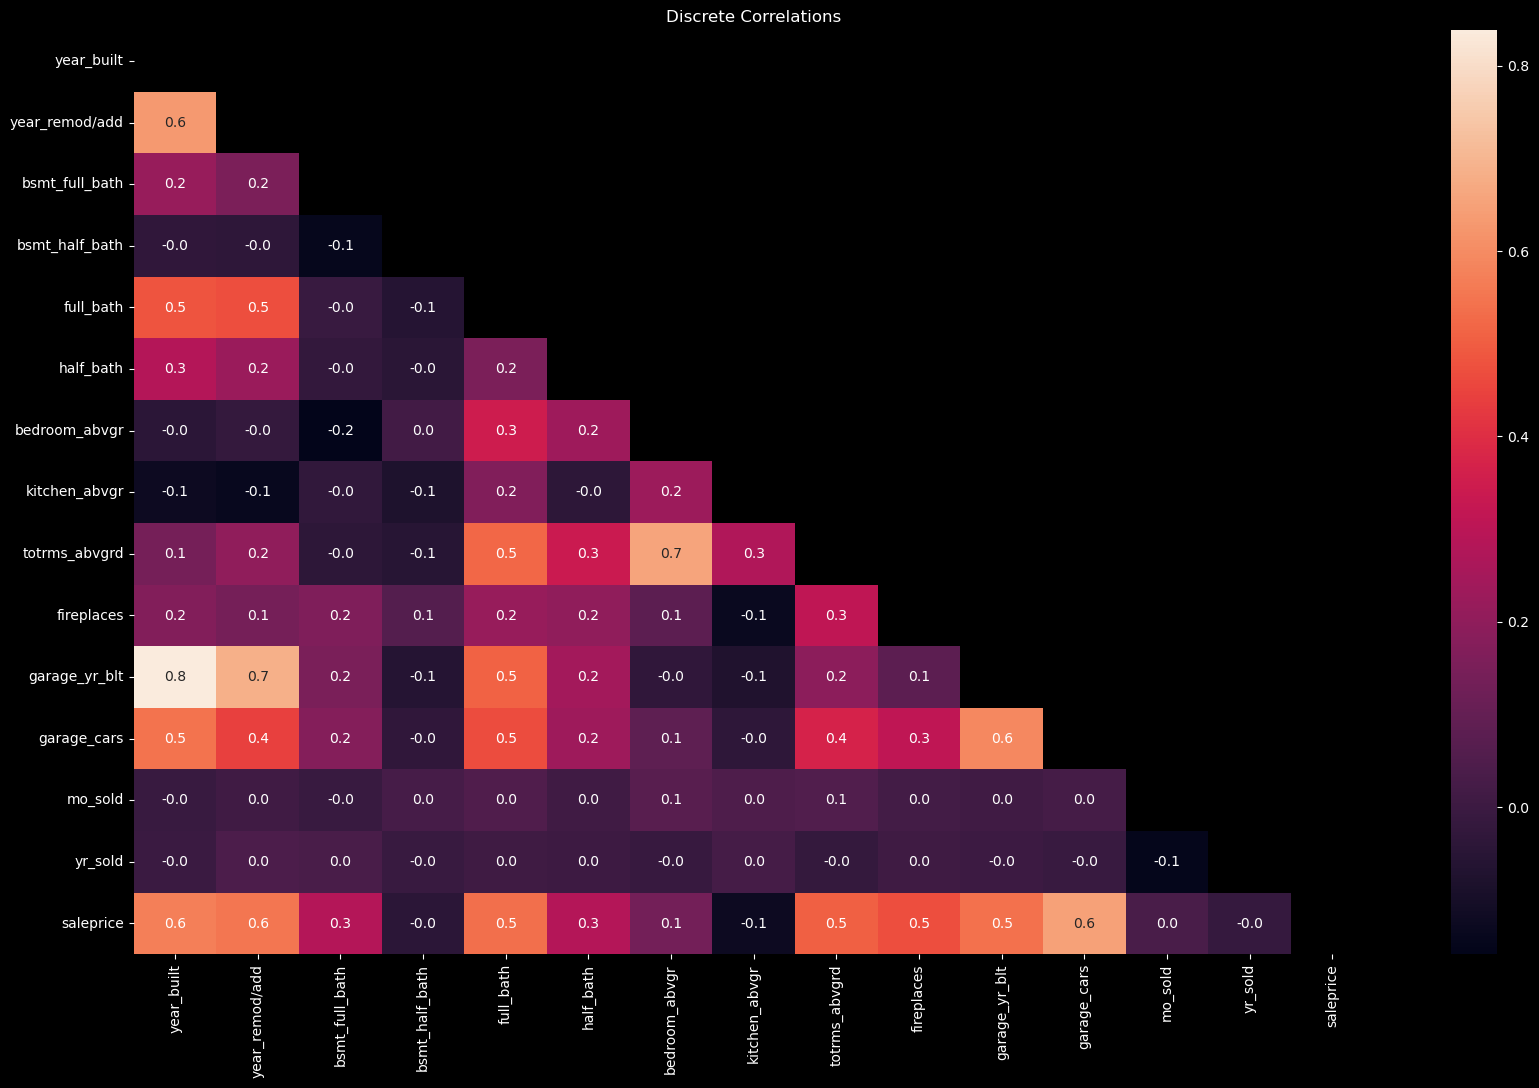

In [1244]:
discrete_corrs = plot_corr_heatmap(house_train, DISCRETE, 'Discrete')

correlative_factors.update(discrete_corrs[1].to_dict())

From the correlation matrix presented above we see a number of features exhibit a positive correlative relationsip with home `saleprice`.

`year_built`, `year_remod/add`, `full_bath`, `garage_yr_blt`, `fireplaces`, `garage_cars` and `full_bath` all had Pearson correlation coefficients over $.50$. This indicates that as a home's sale price increases, the values of these feature also increases.

For the features that represent the year of construction or remodling, the positive correlation implies that the newer the home, or the most recently the home has been remodeled, the higher the `salesprice`. 

# CONTINUOUS features

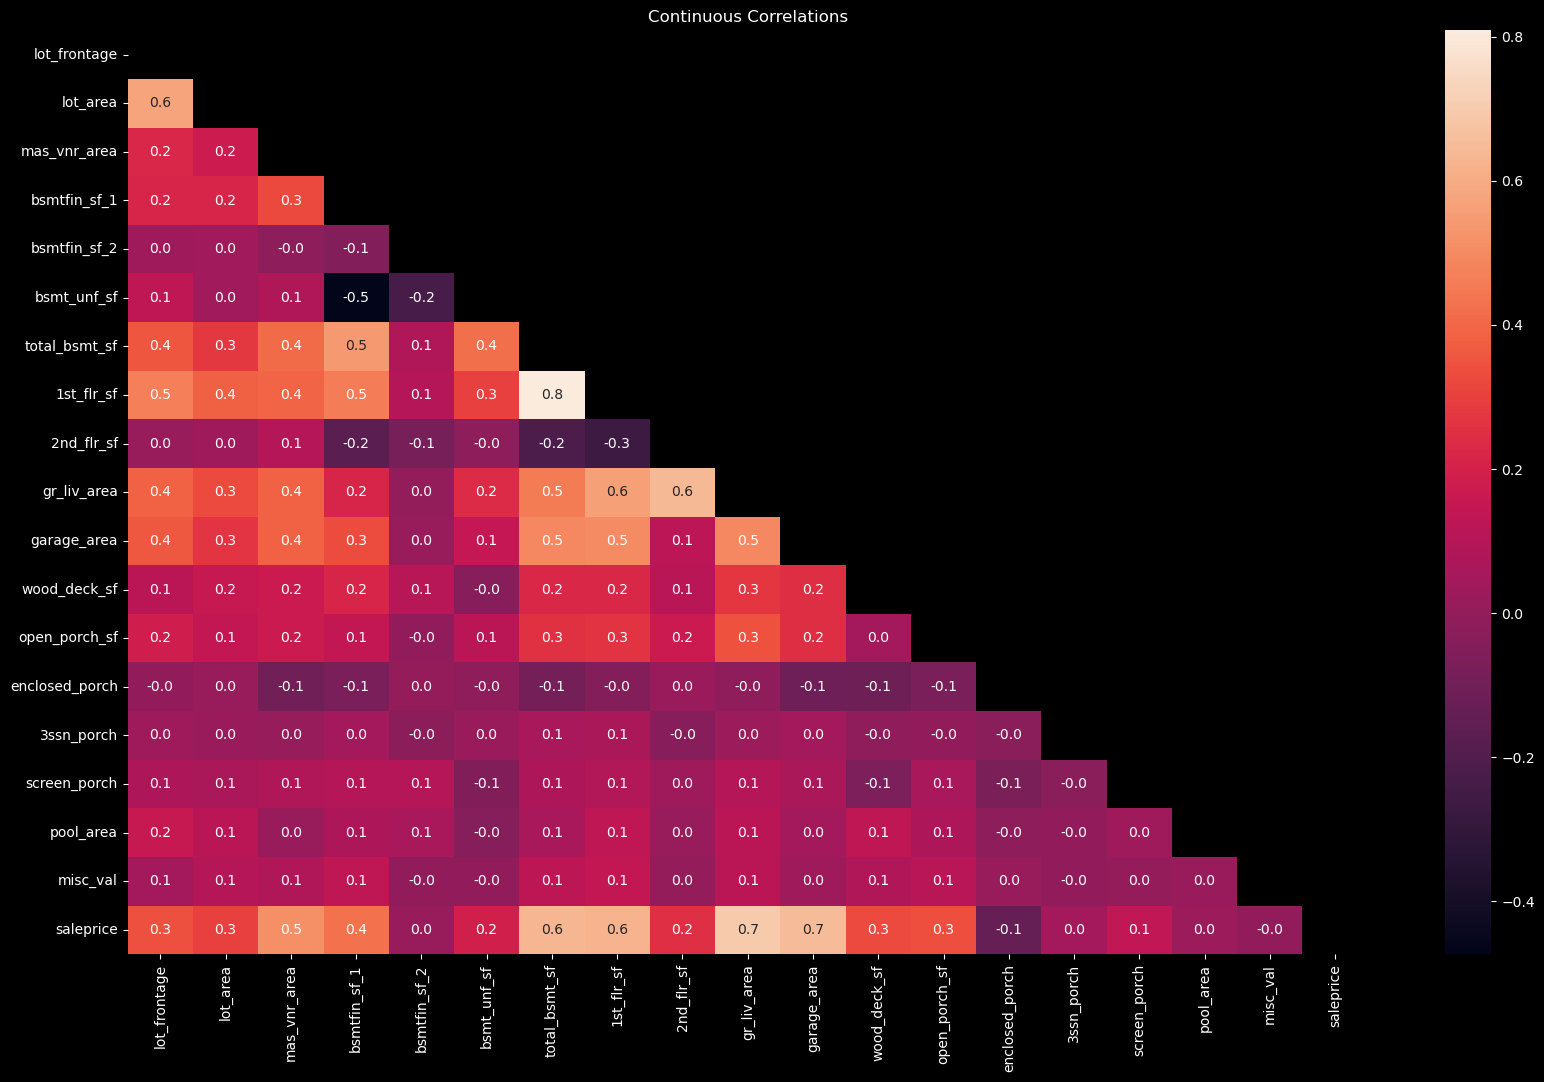

In [1245]:
continuous_corrs = plot_corr_heatmap(house_train, CONTINUOUS, 'Continuous')

correlative_factors.update(continuous_corrs[1].to_dict())

We see that `mas_vnr_area`, `total_bsmt_sf`, `1st_flr_sf`, `gr_liv_area`, and `garage_area` all have Pearson values over $.50$, with the `gr_liv_area` (gross living area)and `garage_area` values having values over $.70$, which constitutes a strong correlative relationship. This comports with common sense and the prevailing thinking in real-estate hedonic pricing--quare footage is a key factor. 

Interestingly, `lot_frontage` and `lot_area` do not have as strong of a correlative relationship to salesprice as `gr_liv_area`. We examine the summary statistics below:


In [1246]:
house_train[['lot_area']].describe()

,lot_area
count,2051.000000
mean,10065.208191
std,6742.488909
min,1300.000000
25%,7500.000000
50%,9430.000000
75%,11513.500000
max,159000.000000



`lot_area` is an interesting value, as a larger number may or may not be a positive selling point. The summary statistics for lot area are presented below, and we see a large spread in the data with a mean value of $10,000$ sqft but a maximum value of $159,000$ sqft. A number this large can wrench around distributions so we'll have to keep that in mind as we continue our exploration of the data. 

# ORDINAL features



In order to return Pearson values from the `ORDINAL` values, we must first process them. 

The functions imported from `cleaning_script.py` convert three different ordinal quality ratings to numeric values. The numeric values are then used to calculate the pearson correlation coefficient between `saleprice` and the feature. The three different `ORDINAL` schemas are similar in that their clear hierarchical ordering lends itself to simple numerical imputation. 

For the `functional` feature, the category values imply a clear positive to negative distribution, so we will set **Typical Functionality** as the maximum value, $3$ and **Salvage Only** as the worst possible value, at $-3$. Otherwise, we set the highest categorical value as the maximum length of the list and order the values from the maximum value to $0$, so **Excellent** gets the maximum value and **Poor** gets the lowest value.

#### The schemas are:

Many Columns:

       ex	excellent
       gd	good
       ta	average/typical
       fa	fair
       po	poor

BsmtFin Type 1 & 2	(Ordinal): Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

Functional (Ordinal): Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only


Find the columns in dataset that use the 'Ex - Po' rating schema

In [1247]:
def ex_po(df):
    rank_words = ['Ex', 'Gd', 'TA','Fa', 'Po']
    rank_words = pd.Series(rank_words)
    columns_to_fix = []

# find columns, append to columns to fix
    for col in df[ORDINAL].columns:
        word_check = rank_words.isin(df[ORDINAL][col])
        if word_check.sum() > 0:
            columns_to_fix.append(col)
            
# convert columns to numeric values
    for col in columns_to_fix:
        df[col] = [ordinal_to_numeric_expo(val) for val in df[col]]

We iterate through the `ORDINAL` columns, find the columns that use the 'ex-po' ranking schema and then convert them using the `ex_po` function. We see that the following columns use this system:  

- exter_qual
- exter_cond
- bsmt_qual
- bsmt_cond
- bsmt_exposure
- heating_qc
- kitchen_qual
- garage_qual
- garage_cond

Apply function to features that use "Ex-Po" schema. 

In [1248]:
# expo train
ex_po(house_train)
# expo test
ex_po(house_test)

Apply function to Basements features.

In [1249]:
def glqna(df):
    basement_cols = ['bsmtfin_type_1', 'bsmtfin_type_2']

    for col in basement_cols:
        df[col] = [ordinal_to_numeric_glqna(val) for val in df[col]]

In [1250]:
# glqna train
glqna(house_train)
# glqna test
glqna(house_test)

Apply function to `functional` feature.

In [1251]:
def functional(df):
    df['functional'] = [ordinal_to_numeric_functional(val) for val in df['functional']]

In [1252]:
# functional train
functional(house_train)
# functional test
functional(house_test)

Capture `ORDINAL` correlations. 

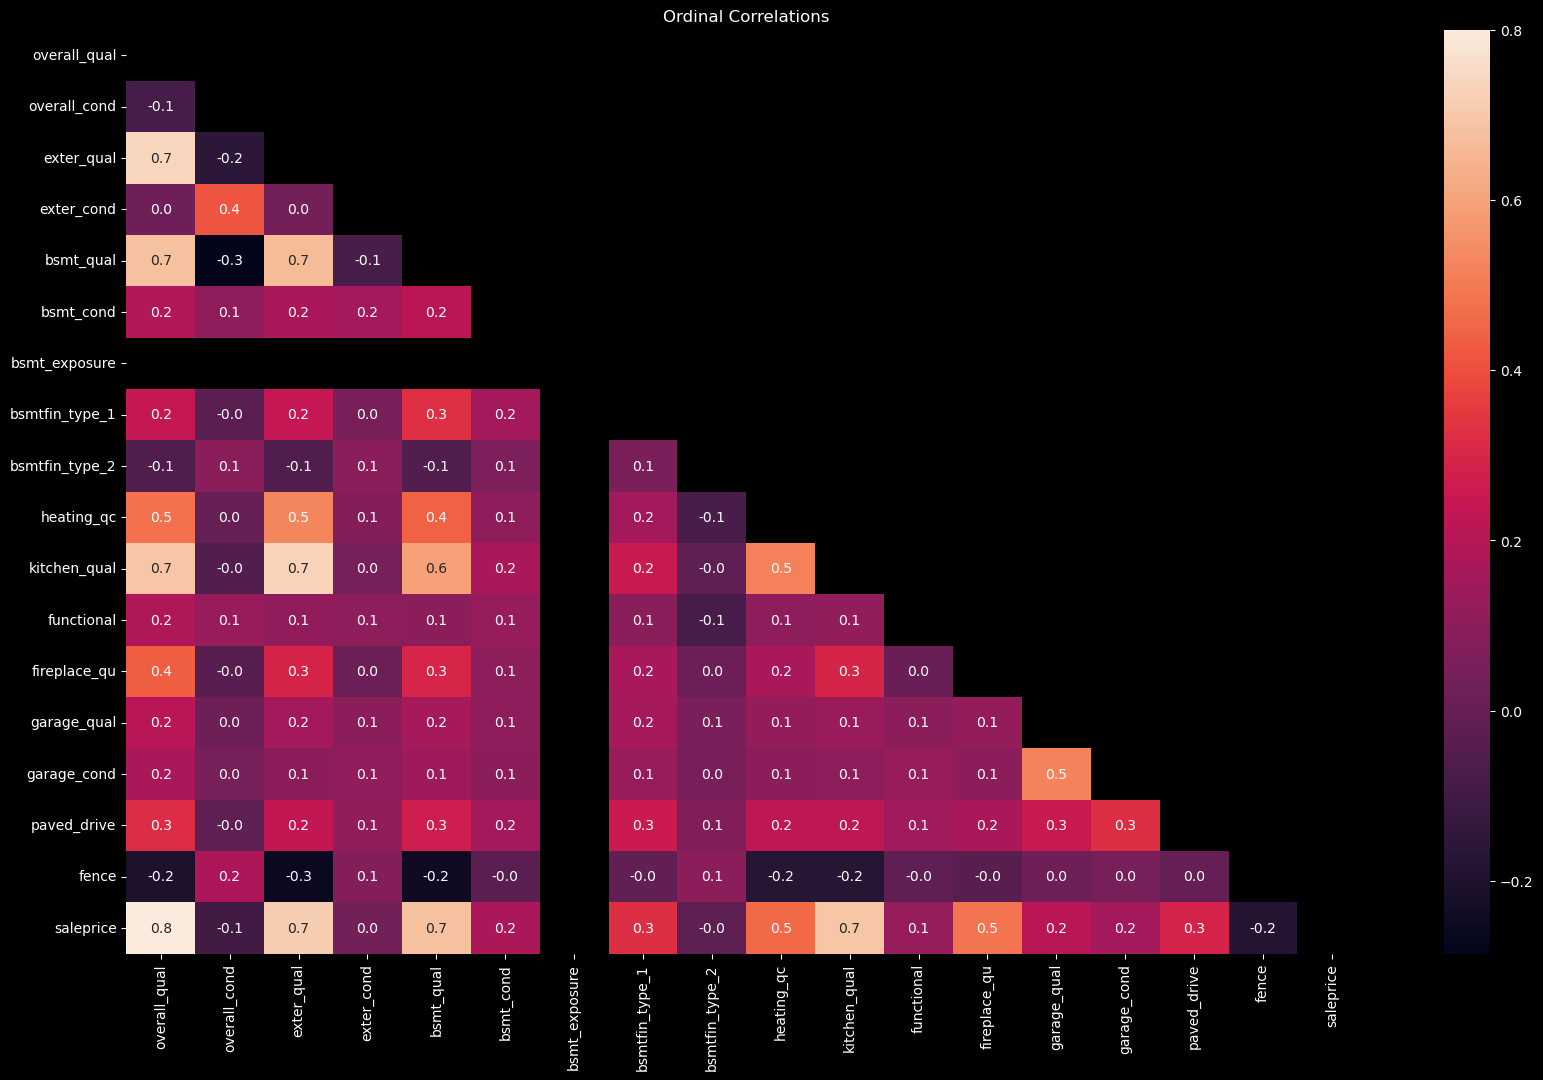

In [1253]:
ordinal_corrs = plot_corr_heatmap(house_train, ORDINAL, 'Ordinal')

correlative_factors.update(ordinal_corrs[1].to_dict())

The returned Pearson values demonstrate the trend discovered in the `CONTINUOUS` and `DISCRETE` correlation matrices: quality is important. We look at the correlation values for `overall_qual`, `exter_qual`, `bsmt_qual` and `kitchen_qual` and note that they have a strong correlative effect on sales price. Additional quality features that have a correlative effect are `heating_qc` and `fireplace_qc`. 

# NOMINAL features

The `NOMINAL` features do not lend themselves to clear numerical ordering, so we will convert them to boolean features. [Research into influential factors in real estate]('https://www.opendoor.com/articles/factors-that-influence-home-value') value suggests that the following factors need to be considered. 

1. Neighborhood
2. Location
3. Size and useable space
4. Age and Condition
5. Updgrades and Updates

With this information in mind, we turn to the dataset and render dummy varaibles. Within the `NOMINAL` features, we will use the `condition_1` feature as a proxy for Location. The data dictionary lists various conditions such as proximity to positive features such as a park as well as proximity to presumably less direable locations, such as a railway. 

The `neighborhood` feature has 23 different neighborhoods that we will render as dummies. 

For condition, we will render the `utilities` , `foundation`, `exterior` and `roof` features as dummies as well. The dataset contains an `overall_qual_cond` feature as well
, but for now we endeavor to extract as much useable information from  dtheataset as we can, and then cut features later as required. 


Location Dummies

In [1254]:
# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['condition_1']).columns.to_list():
    NOMINAL.append(x)

Utility Dummies

In [1255]:
# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['utilities']).columns.to_list():
    NOMINAL.append(x)

Roof Dummies

In [1256]:
# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['roof_matl']).columns.to_list():
    NOMINAL.append(x)

Foundation Dummies

In [1257]:
# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['foundation']).columns.to_list():
    NOMINAL.append(x)

Building Dummies

In [1258]:
# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['bldg_type']).columns.to_list():
    NOMINAL.append(x)

Exterior Dummies

In [1259]:
# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['exterior_1st']).columns.to_list():
    NOMINAL.append(x)

Neighborhood Dummies

In [1260]:
# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['neighborhood']).columns.to_list():
    NOMINAL.append(x)

Concatenate Dummies to main datasets

In [1261]:
# train
house_train = pd.concat([house_train, pd.get_dummies(house_train['condition_1'], drop_first=True),
                                    pd.get_dummies(house_train['neighborhood'],drop_first=True),
                                    pd.get_dummies(house_train['bldg_type'], drop_first=True),
                                    pd.get_dummies(house_train['exterior_1st'], drop_first=True),
                                    pd.get_dummies(house_train['foundation'], drop_first=True),
                                    pd.get_dummies(house_train['roof_matl'], drop_first=True),
                                    pd.get_dummies(house_train['utilities'], drop_first=True),
                                    pd.get_dummies(house_train['condition_1'],drop_first=True)
], axis=1)
# test
house_test = pd.concat([house_test, pd.get_dummies(house_test['condition_1'], drop_first=True),
                                    pd.get_dummies(house_test['neighborhood'],drop_first=True),
                                    pd.get_dummies(house_test['bldg_type'], drop_first=True),
                                    pd.get_dummies(house_test['exterior_1st'], drop_first=True),
                                    pd.get_dummies(house_test['foundation'], drop_first=True),
                                    pd.get_dummies(house_test['roof_matl'], drop_first=True),
                                    pd.get_dummies(house_test['utilities'], drop_first=True),
                                    pd.get_dummies(house_test['condition_1'],drop_first=True)
], axis=1)


# remove the dropped dummy columns from NOMINAL so we have N-1 dummies
for x in ['Artery', 'AllPub', 'ClyTile', 'BrkTil', '1Fam', 'AsbShng', 'Blmngtn']:
    NOMINAL.remove(x)

In [1262]:
len(NOMINAL)

86

Capture `NOMINAL` correlations I.

The dummy variable creation has made the `NOMINAL` data set quite large, with $86$ features now, so we split the correlation analysis into three parts for readability.

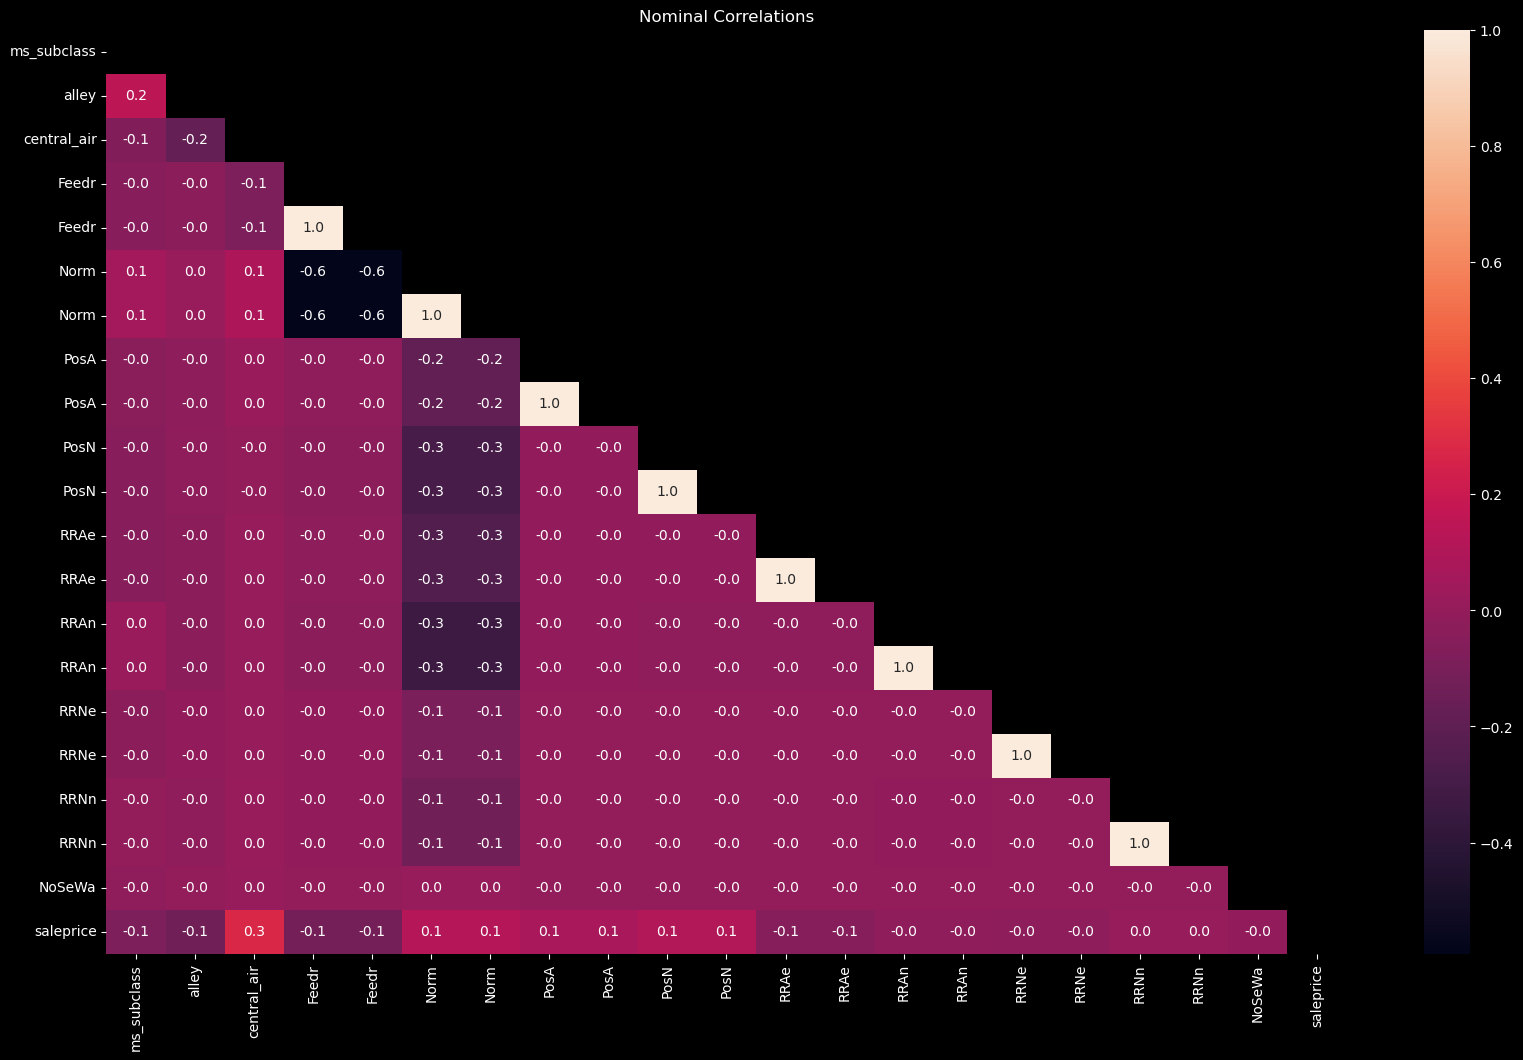

In [1263]:
nominal_corrs_1 = plot_corr_heatmap(house_train, NOMINAL[:30], 'Nominal')

correlative_factors.update(nominal_corrs_1[1].to_dict())

The results above are mostly inconclusive, `central_air` seems to have a slight positive correlative effect on sales price as well as `Norm` and `PosA` and `PosN`. 

From the data dictionary, `Norm` means the house is not located next to a busy street or railroad, nor is it located near what the data dictionary describes as a "positive off-site feature" such as a park. `PosA` and `PosN` represent proximity to "positive" features and show a slight positive correlation, whereas proximity to a railroad `RRAe` shows a slight negative correlation. 

Capture `NOMINAL` correlations II.

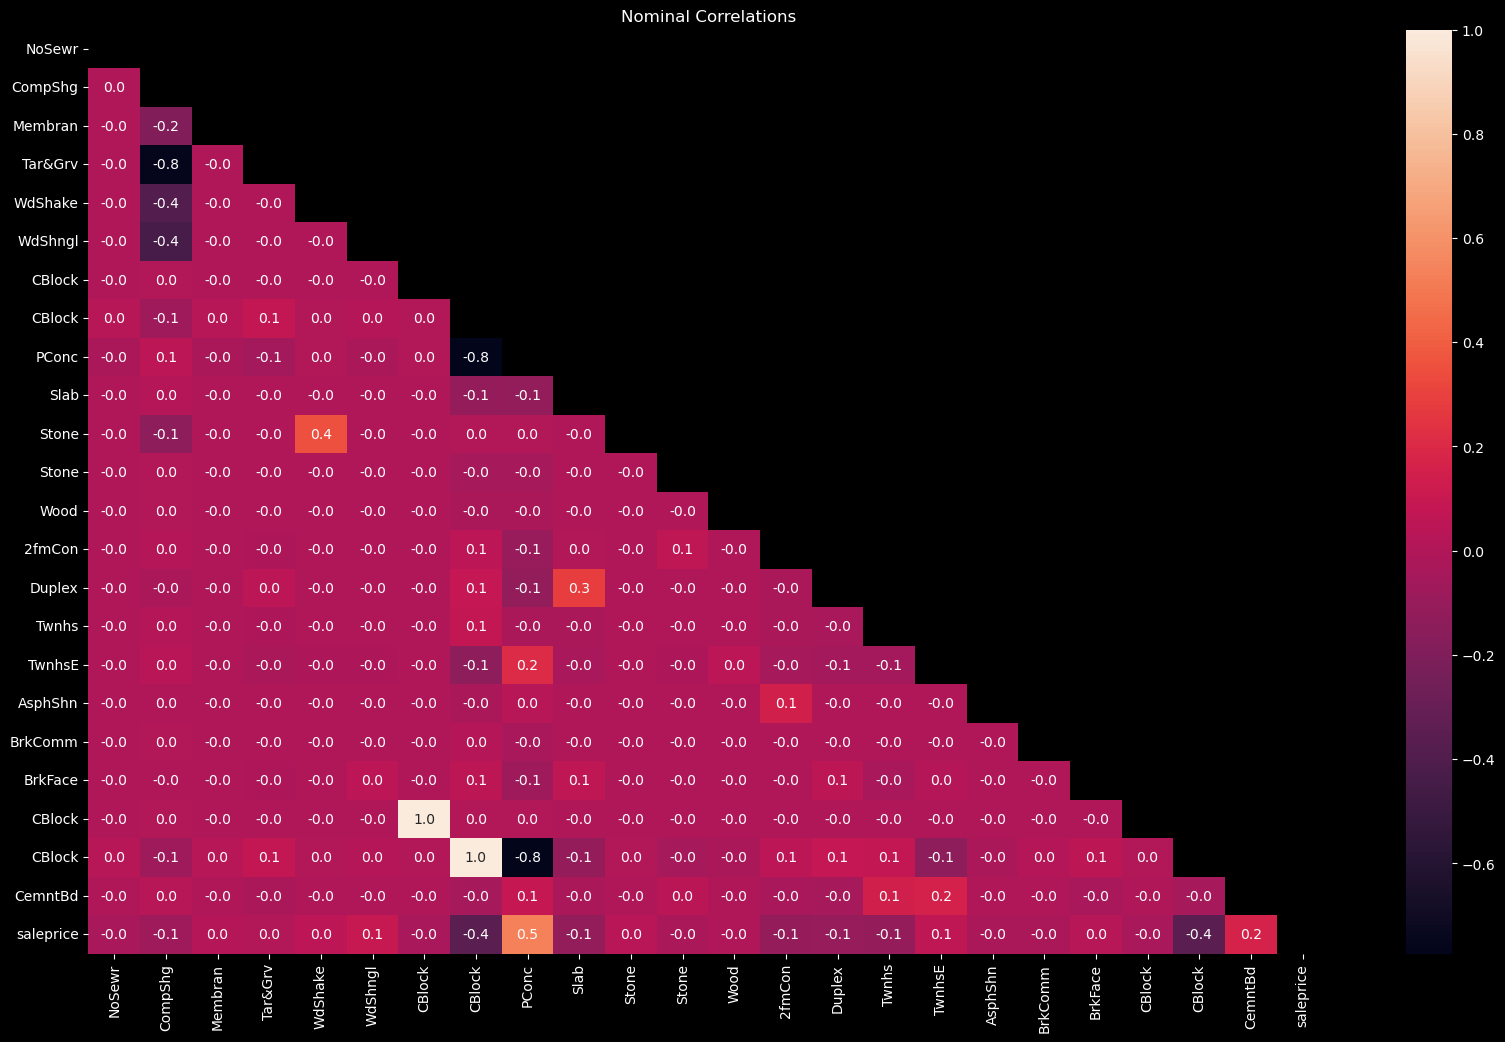

In [1264]:
nominal_corrs_2 = plot_corr_heatmap(house_train, NOMINAL[30:50], 'Nominal')

correlative_factors.update(nominal_corrs_2[1].to_dict())

In [1265]:
# summary statistics for CBlock foundation

print('Cinder Block Foundation Summary Statistics')
display(house_train.query('CBlock == 1')[['gr_liv_area']].describe())

# summary statistics for PConc foundation

print('Poured Concrete Foundation Summary Statistics')
house_train.query('PConc == 1')[['gr_liv_area']].describe()


Cinder Block Foundation Summary Statistics


,gr_liv_area
count,863.000000
mean,1328.595597
std,423.256933
min,438.000000
25%,1026.500000
50%,1232.000000
75%,1560.000000
max,3395.000000


Poured Concrete Foundation Summary Statistics


,gr_liv_area
count,926.000000
mean,1681.497840
std,488.923295
min,672.000000
25%,1368.500000
50%,1614.000000
75%,1901.000000
max,5642.000000


The results above show a Pearson value of $.50$ for `PConc` or a poured concrete foundation, with an almost equally strong *negative* correlation for `CBlock` or cinder block foundation. When paired with square footage, we see that foundation type is serving as proxy variable for square footage. A home with a cinder block foundation is unlikely to be larger than a home with a poured concrete foundation due to structural concerns. 

Capture `NOMINAL` correlations III.

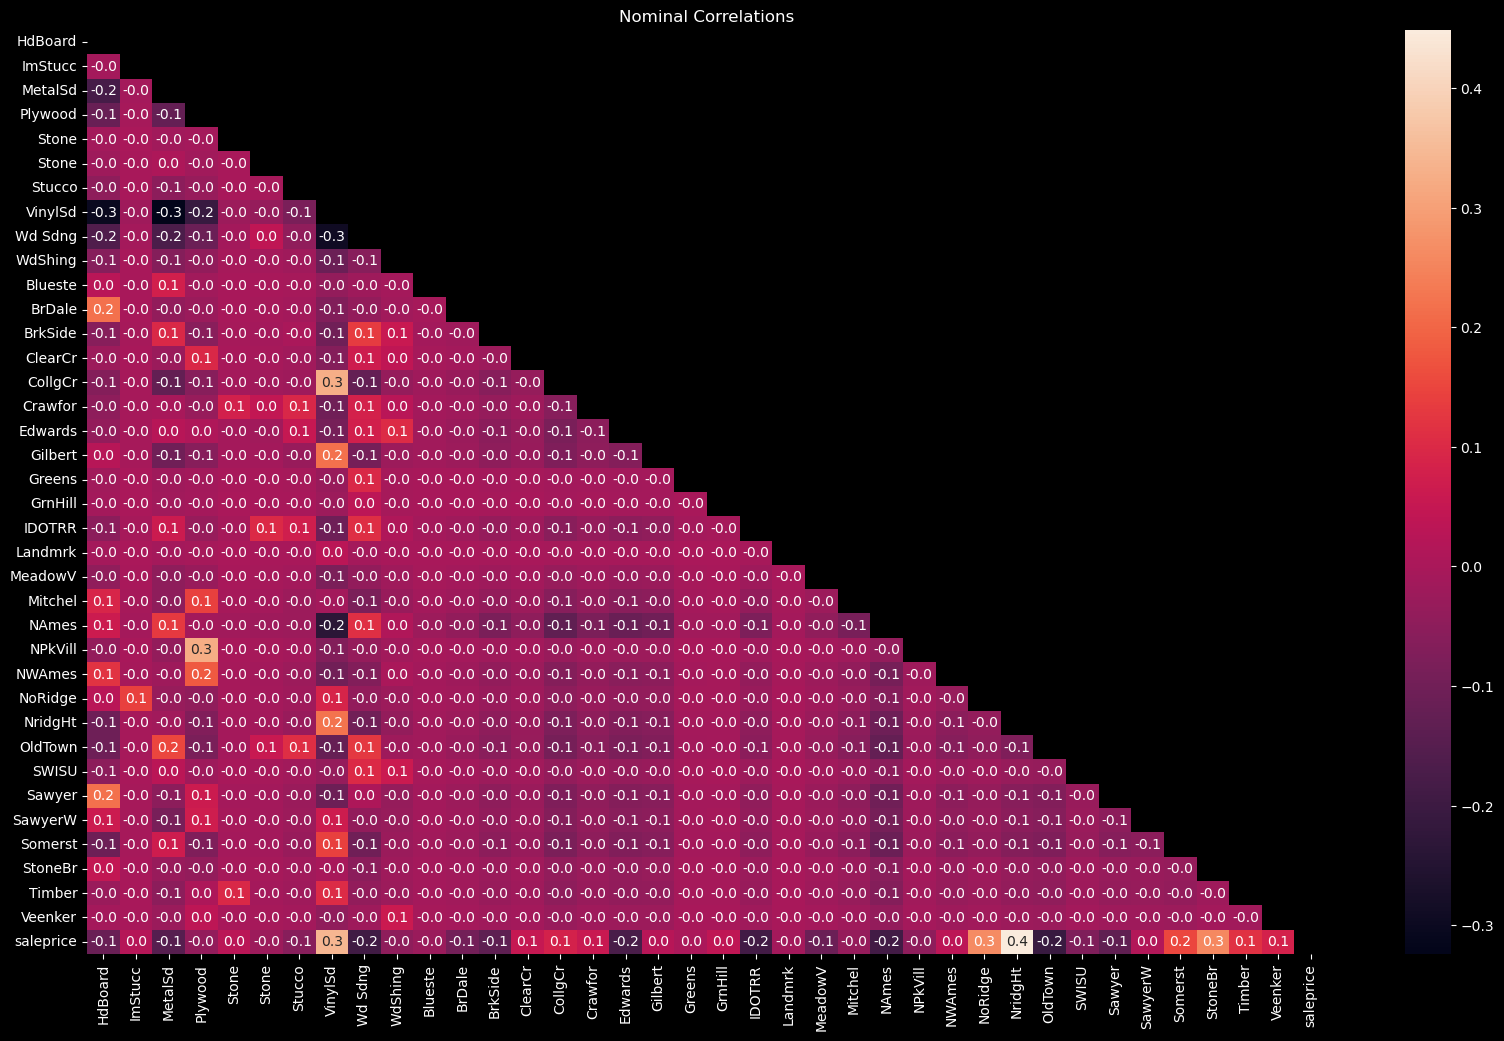

In [1266]:
nominal_corrs_3 = plot_corr_heatmap(house_train, NOMINAL[50:], 'Nominal')

correlative_factors.update(nominal_corrs_3[1].to_dict())

In [1267]:
# summary statistics for vinyl siding exterior
display(house_train.query('VinylSd == 1')[['year_built']].describe())

# summary statistics for Wd Sdng exterior
house_train.query('`Wd Sdng` == 1')[['year_built']].describe()

,year_built
count,724.000000
mean,1993.017956
std,23.580848
min,1875.000000
25%,1996.000000
50%,2003.000000
75%,2005.250000
max,2009.000000


,year_built
count,276.000000
mean,1941.492754
std,22.823352
min,1879.000000
25%,1923.750000
50%,1941.500000
75%,1957.000000
max,1998.000000


The results above show that some neighborhoods have a stronger correlative relationship with salesprice than others, with some neighborhoods exhibiting a negative correlative relationship. This is exactly as we might suspect, as they say in real estate "location, location, location". We also see that some construction materials exhibit a stronger correlative relationship that others, for example `Vinylsd` or vinyl siding has a stronger effect on sales price than `Wdsiding` or wood siding. It is possibe these materials are intrinsically better, but it is more likely they are representing another, stronger, correlative feature.

When paired with `year_built` we see that the home siding is a proxy for home age. The mean year built for homes with wood siding was 1941, whereas the mean year built for vinyl siding, a more modern material is 1993. As was demonstrated above, there is a positive correlative effect between a newer or more recently renovated home and sales price. 



### Find Most Correlative Factors


In [1268]:
correlative_factors = {k:v for k,v in correlative_factors.items() if np.abs(v) > .1 and k != 'saleprice'}

# display correlation factors in a dataframe
print(len(correlative_factors))
pd.DataFrame(correlative_factors, index=['Correlation']).T.sort_values(by='Correlation', ascending=False)

66


,Correlation
overall_qual,0.800207
exter_qual,0.712146
gr_liv_area,0.697038
kitchen_qual,0.692336
bsmt_qual,0.678307
garage_area,0.650270
garage_cars,0.648220
total_bsmt_sf,0.628925
1st_flr_sf,0.618486
year_built,0.571849


The end result of our Pearson correlation analysis is a dataframe of features nd their correlation to `saleprice` ranked by the strength of the correlation. We have filtered for values that have an absolute correlation coefficient of $> 10$ %, to create a set of features, including dummary variables that is reduced to $66$ features.

Now that we have narrowed the field of features, we can look to impute missing values on a case by case basis. If a feature is missing values but does not seem to have a correlative effect on sale price, we can toss it from the data. Otherwise we will examine the distribution of the feature and consider the best approach to fill missing values. 

---
# II. Missing Value Imputation for Correlative Factors
---

Display missing values from `correlative_factors` for Training and Test datasets

In [1269]:
missing_train = house_train[correlative_factors.keys()].isnull().sum().sort_values(ascending = False).loc[lambda x: x > 0]

missing_test = house_test[correlative_factors.keys()].isnull().sum().sort_values(ascending = False).loc[lambda x: x > 0]

print(missing_train)
print('*' * 50)
print(missing_test)

lot_frontage      330
garage_cond       114
garage_qual       114
garage_yr_blt     114
bsmtfin_type_1     55
bsmt_cond          55
bsmt_qual          55
mas_vnr_area       22
bsmt_full_bath      2
total_bsmt_sf       1
bsmt_unf_sf         1
bsmtfin_sf_1        1
garage_area         1
garage_cars         1
dtype: int64
**************************************************
lot_frontage      160
garage_qual        45
garage_yr_blt      45
garage_cond        45
bsmt_qual          25
bsmt_cond          25
bsmtfin_type_1     25
mas_vnr_area        1
dtype: int64


`lot_frontage`

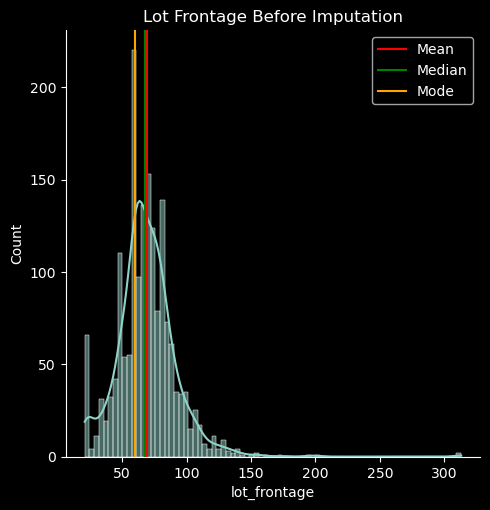

In [1270]:
before = house_train['lot_frontage'].copy()

sns.displot(before, kde=True)
plt.title('Lot Frontage Before Imputation')
plt.axvline(before.mean(), color='red', label='Mean')
plt.axvline(before.median(), color='green', label='Median')
plt.axvline(before.mode()[0], color='orange', label='Mode');
plt.legend()

Lot Frontage is mising 343 values, so we need to take care to not alter the underlying distribution. The plot above shows a close relationship between the mean, median and mode of the distribution--all values are in a range between 60, 70, so we'll impute with the mean and see how it alters the underlying distribution. 

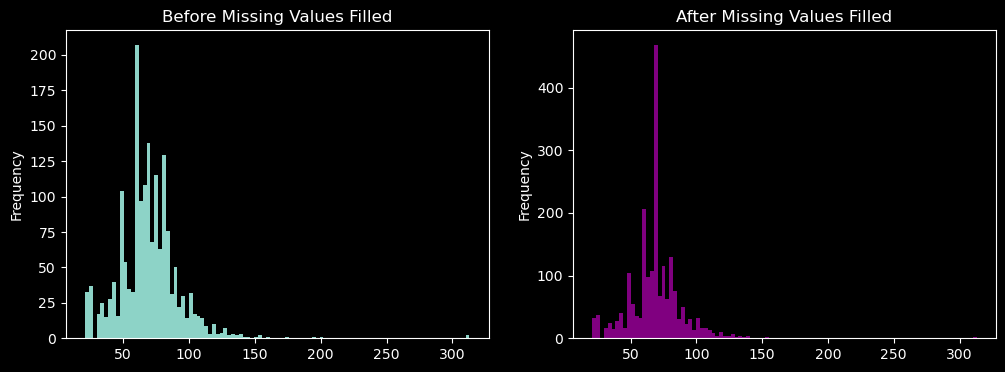

In [1271]:
# train
house_train['lot_frontage'] = house_train.lot_frontage.fillna(house_train.lot_frontage.mean())
# test
house_test['lot_frontage'] = house_test.lot_frontage.fillna(house_test.lot_frontage.mean())

# plot
fig, axes = plt.subplots(1,2, figsize=(12,4))

before.plot.hist(bins=100, ax = axes[0], title='Before Missing Values Filled')
house_train['lot_frontage'].plot.hist(bins=100, ax = axes[1], color = 'purple', title = 'After Missing Values Filled');

We've altered the tales of the distribution slightly but overall it looks O.K. and now that we've filled the 343 missing values we can try to use the column in our regression model. 

In [1272]:
# check for missing values
house_train.lot_frontage.isnull().sum()

0

`mas_vnr_area`

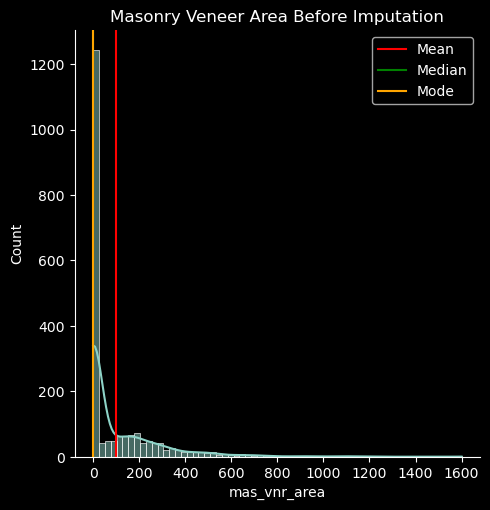

In [1273]:
before = house_train['mas_vnr_area'].copy()
sns.displot(before, kde=True)
plt.title('Masonry Veneer Area Before Imputation')
plt.axvline(before.mean(), color='red', label='Mean')
plt.axvline(before.median(), color='green', label='Median')
plt.axvline(before.mode()[0], color='orange', label='Mode');
plt.legend();

The `mas_vnr_area` feature is a measure of measurement of masonry, which many home clearly do not have, exhibited by the huge number of $0's$ in the distribution. We'll impute the 22 missing values with $0$. 

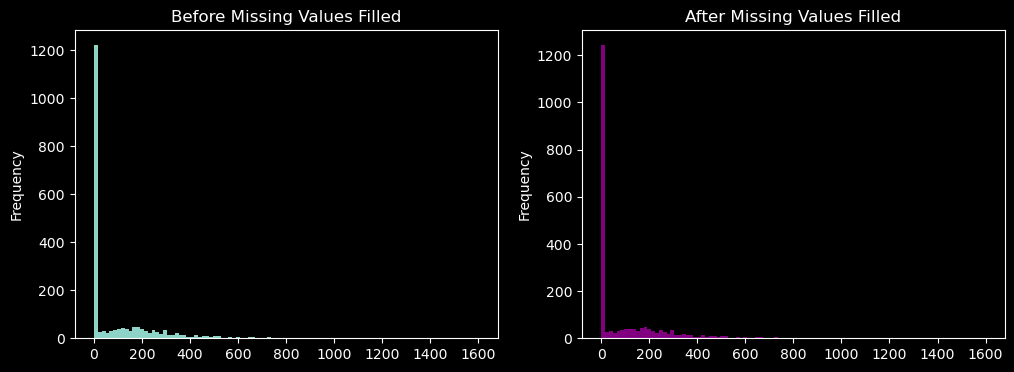

In [1274]:

# train
house_train['mas_vnr_area'] = house_train.mas_vnr_area.fillna(0) # 0 is the mode, overwhelmingly the case
# test
house_test['mas_vnr_area'] = house_test.mas_vnr_area.fillna(0)

fig, axes = plt.subplots(1,2, figsize=(12,4))

before.plot.hist(bins=100, ax = axes[0], title='Before Missing Values Filled')
house_train['mas_vnr_area'].plot.hist(bins=100, ax = axes[1], color = 'purple', title = 'After Missing Values Filled');

We didn't alter the distribution in any noticeable way, the number of $0$'s drowns everything else out, and we only filled 22 missing values. 

`bsmtfin_type_1`

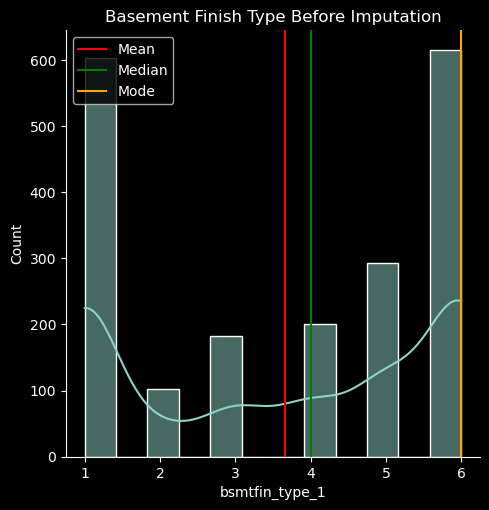

In [1275]:
before = house_train['bsmtfin_type_1']
sns.displot(before, kde=True)
plt.title('Basement Finish Type Before Imputation')
plt.axvline(before.mean(), color='red', label='Mean')
plt.axvline(before.median(), color='green', label='Median')
plt.axvline(before.mode()[0], color='orange', label='Mode');
plt.legend();

The `bsmtfin_type_1` distribution is *bimodal*. The mean and median don't seem to represent the data well as the majority of the values are either a $1$ or a $6$. In this case a 6 represents a finished basement with "Good Living Quarters" and a 1 represents an uninfished basement. It is difficult to know what value to impute, so we will randomly impute values based on their proportion in the underlying distribution. The function below manages that. 

In [1276]:
def random_bsmt_imputation(df):
    weights = []
# find distribution of scores amongst the values we have aren't NaN, append proportions to weights
    for x in range(1,7):
        weights.append(
        len(df.query(f'bsmtfin_type_1 == {x} and bsmtfin_type_1.notna()'))/
        len(df.query(f'bsmtfin_type_1.notna()'))
        )

# use proportions as probability weights for random assignment of values
    df['bsmtfin_type_1'] = df.bsmtfin_type_1.fillna(np.random.choice(np.arange(1,7), p=weights))

# train
random_bsmt_imputation(house_train)
# test
random_bsmt_imputation(house_test)


We only impute for 1 missing value so we don't render the before/after plots as the difference wouldn't be noticeable. 

`bsmt_full_bath`

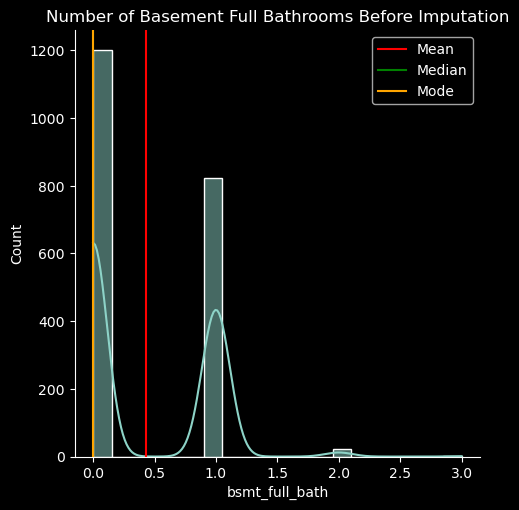

In [1277]:
before = house_train.bsmt_full_bath

sns.displot(before, kde=True)
plt.title('Number of Basement Full Bathrooms Before Imputation')
plt.axvline(before.mean(), color='red', label='Mean')
plt.axvline(before.median(), color='green', label='Median')
plt.axvline(before.mode()[0], color='orange', label='Mode');
plt.legend();

We again see a bimodal distribution, we'll use the same random selection process designed above to impute the missing value. 

In [1278]:

def random_bathroom_imputation(df):
    weights = []
# find distribution of scores amongst the values have aren't NaN, append proportions to weights
    for x in range(0,3):
        weights.append(
        len(df.query(f'bsmt_full_bath == {x} and bsmt_full_bath.notna()'))/
        len(df.query(f'bsmt_full_bath.notna()'))
        )

# normalize so numpy doesn't flag .9998 as not being 1.0
    weights = np.array(weights)
    weights /= weights.sum()

# use proportions as probability weights for random assignment of values
    df['bsmt_full_bath'] = df.bsmt_full_bath.fillna(np.random.choice(np.arange(0,3), p=weights))
    
# train
random_bathroom_imputation(house_train)
# test
random_bathroom_imputation(house_test)

We only impute for 1 missing value so we don't render the before/after plots as the difference wouldn't be noticeable. 

`bsmtfin_sf_1`

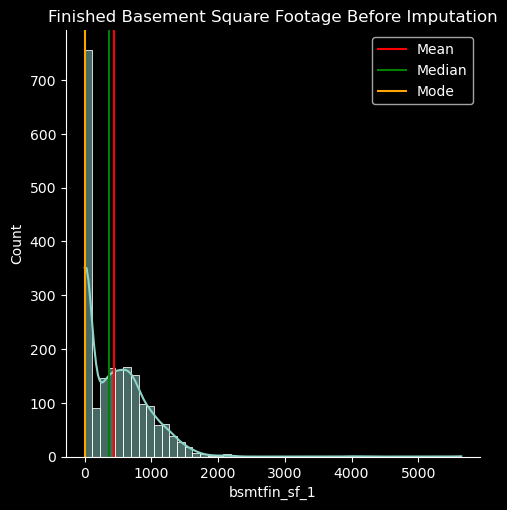

In [1279]:
before = house_train.bsmtfin_sf_1
sns.displot(before, kde=True)
plt.title('Finished Basement Square Footage Before Imputation')
plt.axvline(before.mean(), color='red', label='Mean')
plt.axvline(before.median(), color='green', label='Median')
plt.axvline(before.mode()[0], color='orange', label='Mode');
plt.legend();

Similar to finished basement quality, the distribution suggests that, if a home hase a basement, the home either has a finished basement or an unfinished basement. The mode is $0$ and is the overwhelming majority of the distribution, so we'll impute a $0$. 

In [1280]:
# train
house_train['bsmtfin_sf_1'] = house_train.bsmtfin_sf_1.fillna(0) # 0 is the mode, overwhelmingly the case
# test
house_test['bsmtfin_sf_1'] = house_test.bsmtfin_sf_1.fillna(0) # 0 is the mode, overwhelmingly the case

We only impute for 1 missing value so we don't render the before/after plots as the difference wouldn't be noticeable. 

`garage_yr_blt`

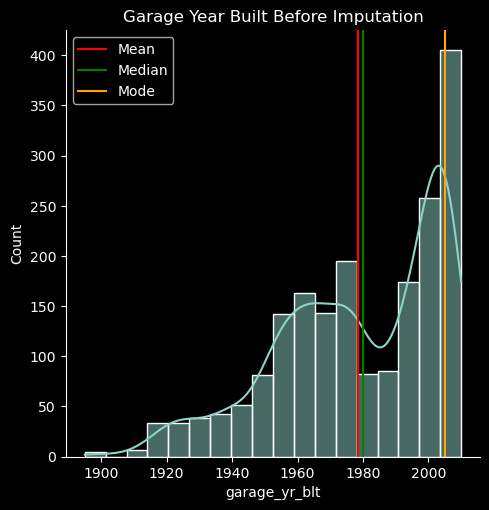

In [1281]:
before = house_train['garage_yr_blt']

sns.displot(before, kde=True)
plt.title('Garage Year Built Before Imputation')
plt.axvline(before.mean(), color='red', label='Mean')
plt.axvline(before.median(), color='green', label='Median')
plt.axvline(before.mode()[0], color='orange', label='Mode');
plt.legend();

The distribution of `garage_yr_blt` has a left skew and suggests that the majority of the housing stock in Ames has a recently constructed or integral garage. Imputing the mean or median-which are both around 1980-will skew the distribution away from the overwheming majority of the construction data, so we will impute the mode. 

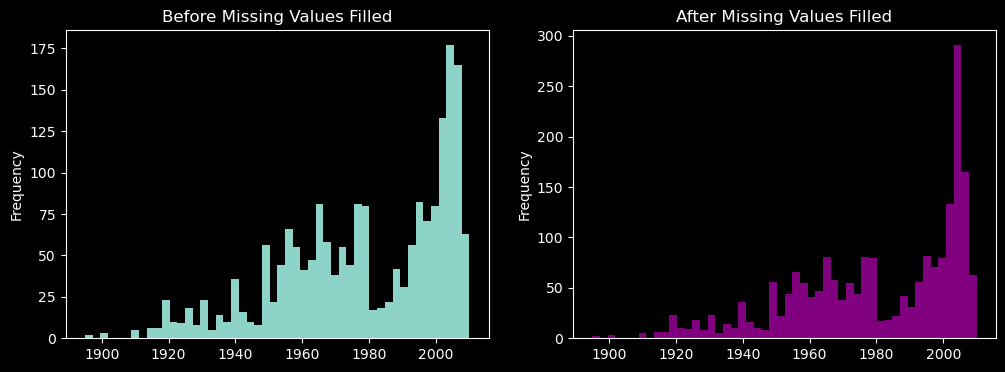

In [1282]:
# the mean and median for garage_yr_built are all 1978, the mode is 2005

# train
house_train['garage_yr_blt'] = house_train.garage_yr_blt.fillna(2005)
# test
house_test['garage_yr_blt'] = house_test.garage_yr_blt.fillna(2005)

fig, axes = plt.subplots(1,2, figsize=(12,4))

# plot
before.plot.hist(bins=50, ax = axes[0], title='Before Missing Values Filled')
house_train['garage_yr_blt'].plot.hist(bins=50, ax = axes[1], color = 'purple', title = 'After Missing Values Filled');

The distributions look quite similar, we don't seem to have altered the underlying distribution in any clear way. 

`garage_qual`

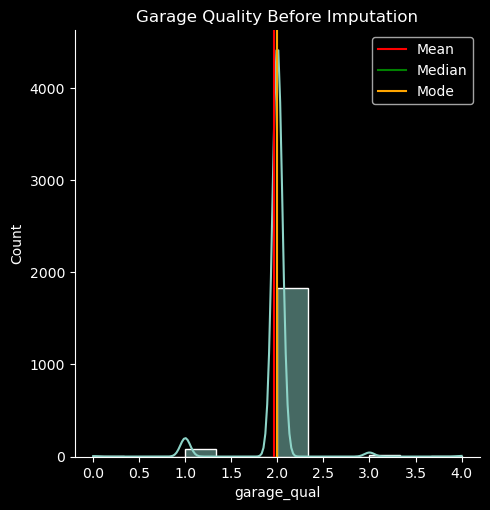

In [1283]:

before = house_train['garage_qual']
sns.displot(before, kde=True)
plt.title('Garage Quality Before Imputation')
plt.axvline(before.mean(), color='red', label='Mean')
plt.axvline(before.median(), color='green', label='Median')
plt.axvline(before.mode()[0], color='orange', label='Mode');
plt.legend();


The mean, median and mode are all so similar that we can choose either of them and it likely won't alter the underlying distribution.

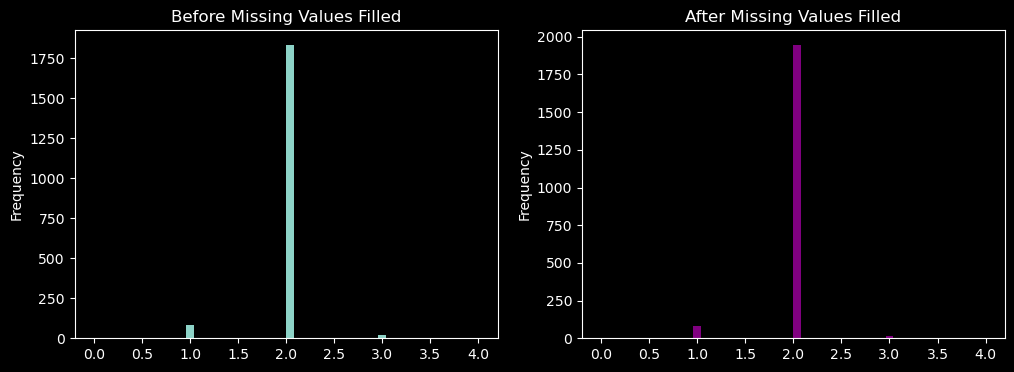

In [1284]:
# the mean, median  and modefor garage_qual are 2

# train
house_train['garage_qual'] = house_train.garage_qual.fillna(2)
# test
house_test['garage_qual'] = house_test.garage_qual.fillna(2)
fig, axes = plt.subplots(1,2, figsize=(12,4))

before.plot.hist(bins=50, ax = axes[0], title='Before Missing Values Filled')
house_train['garage_qual'].plot.hist(bins=50, ax = axes[1], color = 'purple', title = 'After Missing Values Filled');

We haven't altered the underlying distribution in any noticeable way. 

`garage_condition`

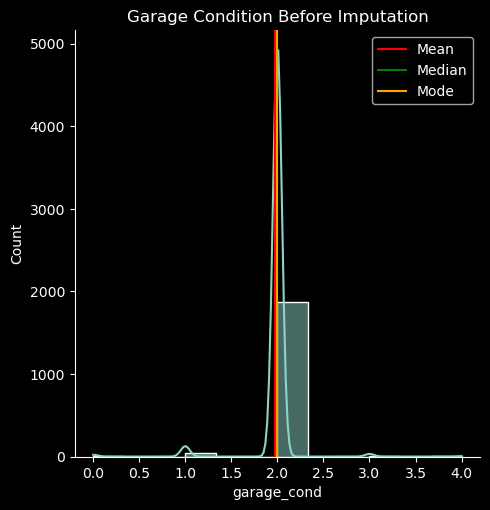

In [1285]:

before = house_train['garage_cond']
sns.displot(before, kde=True)
plt.title('Garage Condition Before Imputation')
plt.axvline(before.mean(), color='red', label='Mean')
plt.axvline(before.median(), color='green', label='Median')
plt.axvline(before.mode()[0], color='orange', label='Mode');
plt.legend();


Much like `garage_qual`, the mean, median and mode are so similar that we can impute either value and we won't alter the underlying distribution much.  

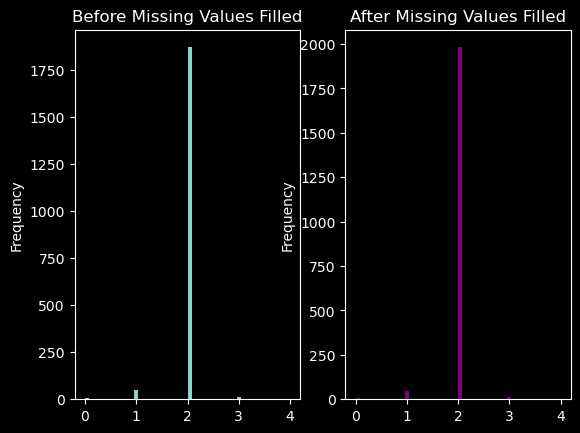

In [1286]:
# the mean, median  and modefor garage_cond are 2
# train
house_train['garage_cond'] = house_train.garage_cond.fillna(2)
# test
house_test['garage_cond'] = house_test.garage_cond.fillna(2)
fig, axes = plt.subplots(1,2)

before.plot.hist(bins=50, ax = axes[0], title='Before Missing Values Filled')
house_train['garage_cond'].plot.hist(bins=50, ax = axes[1], color = 'purple', title = 'After Missing Values Filled');

The distribution looks unaltered. 

`bsmt_cond`

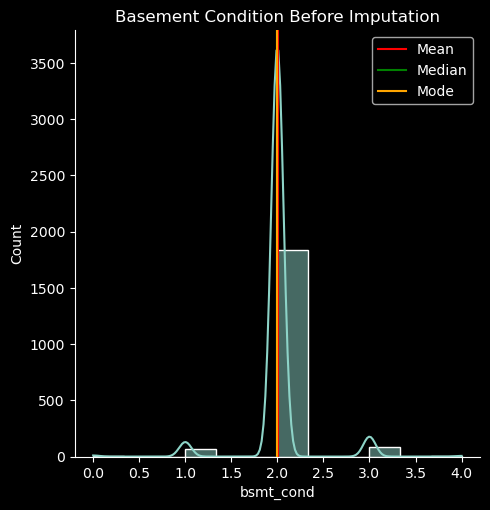

In [1287]:
before = house_train['bsmt_cond']

sns.displot(before, kde=True)
plt.title('Basement Condition Before Imputation')
plt.axvline(before.mean(), color='red', label='Mean')
plt.axvline(before.median(), color='green', label='Median')
plt.axvline(before.mode()[0], color='orange', label='Mode');
plt.legend();

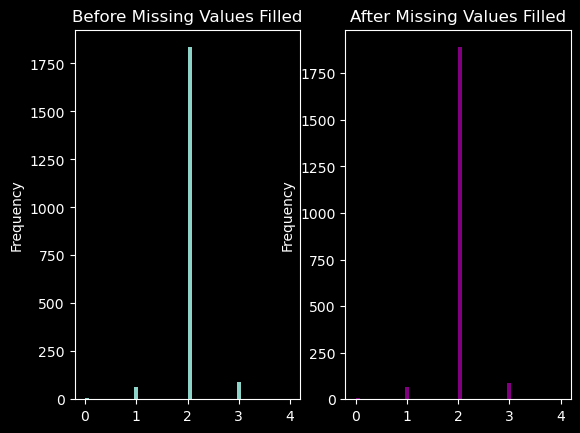

In [1288]:

# the mean, median  and modefor sement_cond are 2
# train
house_train['bsmt_cond'] = house_train.bsmt_cond.fillna(2)
# test
house_test['bsmt_cond'] = house_test.bsmt_cond.fillna(2)
fig, axes = plt.subplots(1,2)

before.plot.hist(bins=50, ax = axes[0], title='Before Missing Values Filled')
house_train['bsmt_cond'].plot.hist(bins=50, ax = axes[1], color = 'purple', title = 'After Missing Values Filled');

`bsmt_qual`

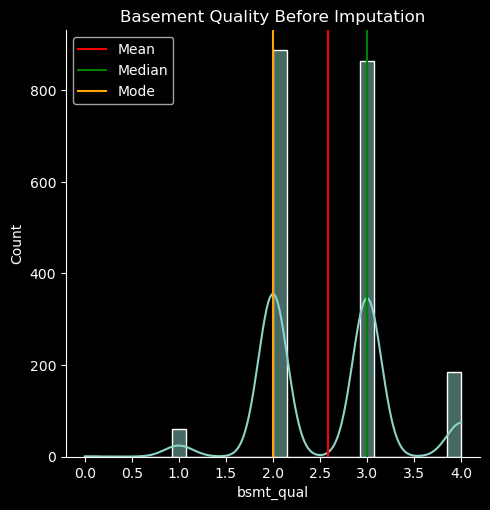

In [1289]:
before = house_train['bsmt_qual'] 
sns.displot(before, kde=True)
plt.title('Basement Quality Before Imputation')
plt.axvline(before.mean(), color='red', label='Mean')
plt.axvline(before.median(), color='green', label='Median')
plt.axvline(before.mode()[0], color='orange', label='Mode');
plt.legend();

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

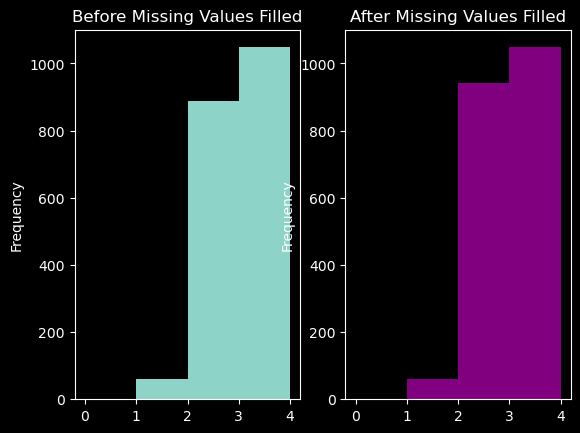

In [1290]:
# mode is 2, median is 3, mean is 2.5

# train
house_train['bsmt_qual'] = house_train.bsmt_qual.fillna(house_train.bsmt_qual.mean())
# test
house_test['bsmt_qual'] = house_test.bsmt_qual.fillna(house_test.bsmt_qual.mean())

# plot
fix, axes = plt.subplots(1, 2)
before.plot.hist(bins=4, ax = axes[0], title='Before Missing Values Filled')
house_train['bsmt_qual'].plot.hist(bins=4, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`bsmt_full_bath`

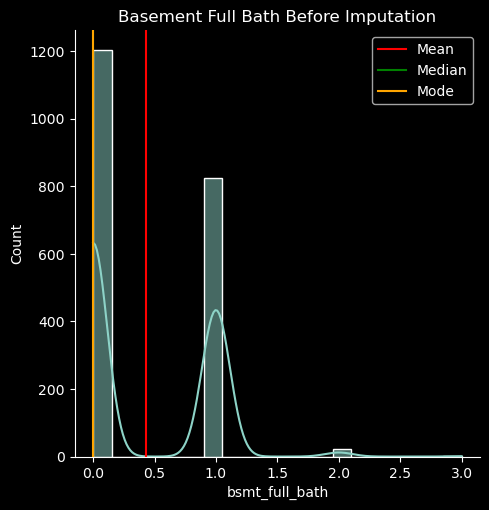

In [1291]:

before = house_train['bsmt_full_bath'] 
sns.displot(before, kde=True)
plt.title('Basement Full Bath Before Imputation')
plt.axvline(before.mean(), color='red', label='Mean')
plt.axvline(before.median(), color='green', label='Median')
plt.axvline(before.mode()[0], color='orange', label='Mode');
plt.legend();

`bsmt_full_bath` has a bimodal distribution, but we're only missing one value so we'll impute the mode. 

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

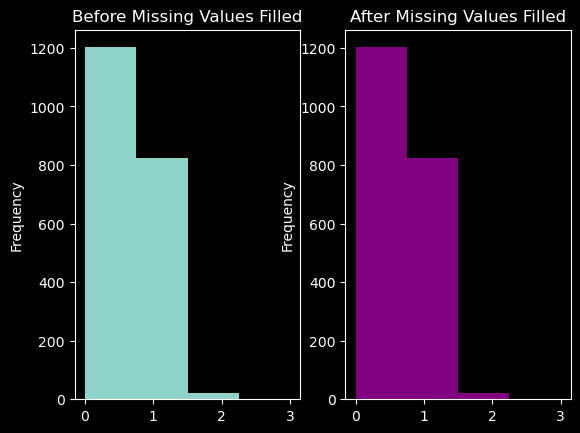

In [1292]:
# mode is 2, median is 3, mean is 2.5

# train
house_train['bsmt_full_bath'] = house_train.bsmt_full_bath.fillna(0)
# test
house_test['bsmt_full_bath'] = house_test.bsmt_full_bath.fillna(0)

# plot
fix, axes = plt.subplots(1, 2)
before.plot.hist(bins=4, ax = axes[0], title='Before Missing Values Filled')
house_train['bsmt_full_bath'].plot.hist(bins=4, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`bsmt_half_bath`

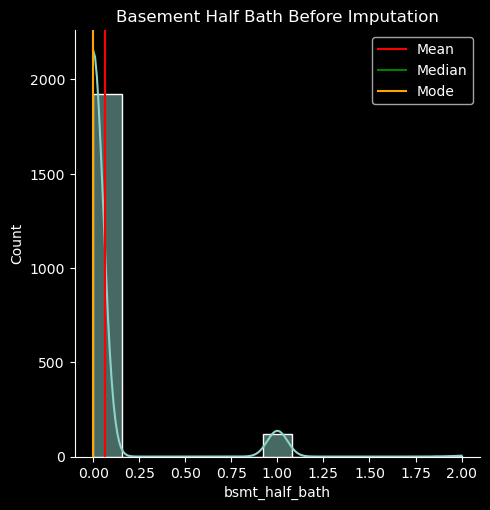

In [1293]:
before = house_train['bsmt_half_bath'] 
sns.displot(before, kde=True)
plt.title('Basement Half Bath Before Imputation')
plt.axvline(before.mean(), color='red', label='Mean')
plt.axvline(before.median(), color='green', label='Median')
plt.axvline(before.mode()[0], color='orange', label='Mode');
plt.legend();

`bsmt_half_bath` is also only missing one value. It seems clear that we'll impute the mode, $0$ as most bathrooms in Ames, IA do not have a half bathroom. 

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

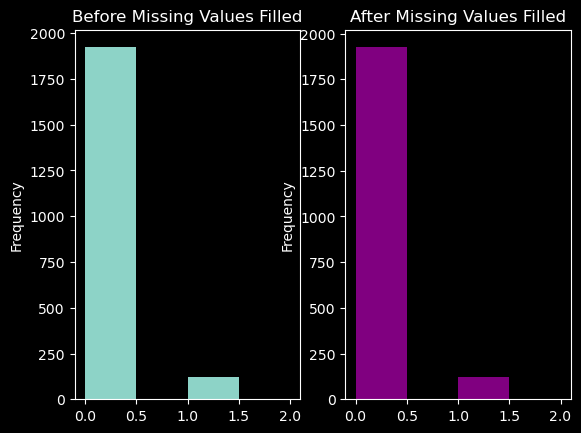

In [1294]:

# train
house_train['bsmt_half_bath'] = house_train.bsmt_half_bath.fillna(house_train.bsmt_half_bath.mean())
# test
house_test['bsmt_half_bath'] = house_test.bsmt_half_bath.fillna(house_test.bsmt_half_bath.mean())

# plot
fix, axes = plt.subplots(1, 2)
before.plot.hist(bins=4, ax = axes[0], title='Before Missing Values Filled')
house_train['bsmt_half_bath'].plot.hist(bins=4, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`garage_area` and `garage_cars`

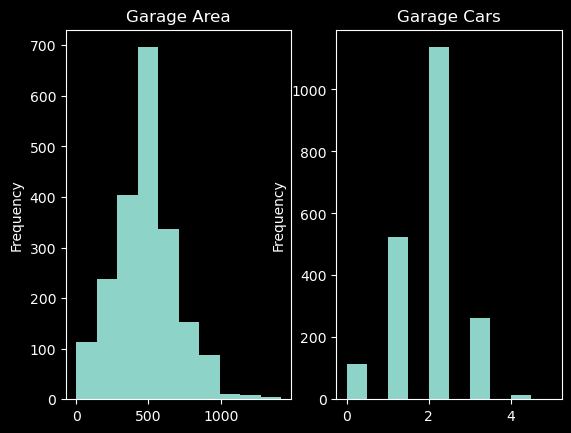

In [1295]:
fix, axes = plt.subplots(1,2)
house_train.garage_area.plot.hist(title='Garage Area', ax=axes[0])
house_train.garage_cars.plot.hist(title='Garage Cars', ax=axes[1]);

`garage_cars` and `garage_area` are both only missing one value and look close to being normally distributed, so we'll impute the median value for both. 

In [1296]:
# both of these are just missing 1 value and are close to normally distributed, so we'll insert the median..

for col in ['garage_cars', 'garage_area']:
    house_train[col] = house_train[col].fillna(house_train[col].median())
    house_test[col] = house_test[col].fillna(house_test[col].median())

`total_bsmt_sqft`

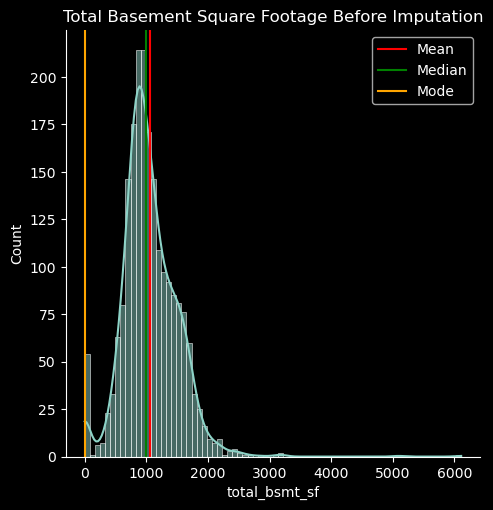

In [1297]:
before = house_train['total_bsmt_sf']
sns.displot(before, kde=True)
plt.title('Total Basement Square Footage Before Imputation')
plt.axvline(before.mean(), color='red', label='Mean')
plt.axvline(before.median(), color='green', label='Median')
plt.axvline(before.mode()[0], color='orange', label='Mode');
plt.legend();


`total_bsmt_sf` is only missing one value, the mean and median are close to each other so we'll impute the mean and not alter the underlying distribution. 

In [1298]:

house_train['total_bsmt_sf'] = house_train.total_bsmt_sf.fillna(house_train.total_bsmt_sf.mean())
house_test['total_bsmt_sf'] = house_test.total_bsmt_sf.fillna(house_test.total_bsmt_sf.mean())

---
# III. Feature Engineering

---

### Combining Correlative Features

In section III. we endeavor to combat multicollinearty by culling the features we've cleaned and"engineer" new features to 
hopefully gain additional predictive power through the interaction between the features.



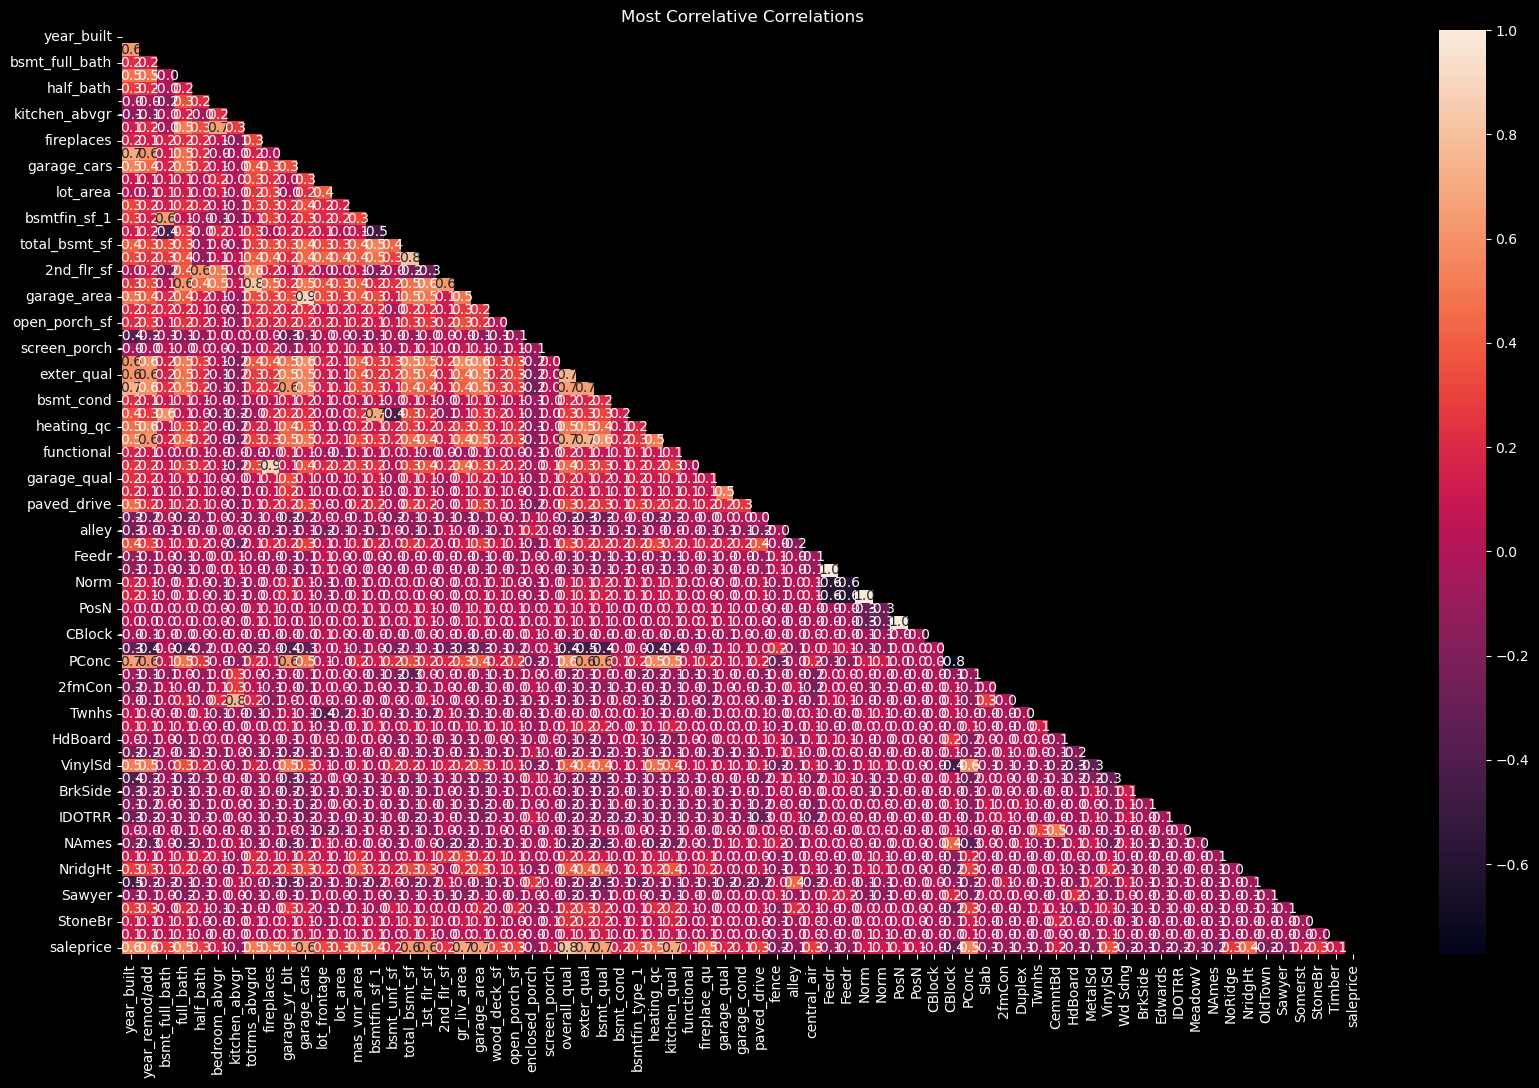

In [1299]:
most_corrs = plot_corr_heatmap(house_train, correlative_factors.keys(), 'Most Correlative')

dict = (most_corrs[2].where(np.triu(np.ones(most_corrs[2].shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))


In [1300]:
correlations_df = pd.DataFrame(dict).rename({0:'corr'}, axis=1).sort_index()

correlations_df.query('corr != 1 and corr != "saleprice"').head()

corr
1st_flr_sf 2fmCon     -0.059936
           2nd_flr_sf -0.268855
           BrkSide    -0.127146
           CBlock      0.004376
           CBlock     -0.092968

In [1301]:
drops = []
engineered = []

### Overall Condition/Quality

In [1302]:
# retrieve pair correlation 
correlations_df.loc[('overall_qual', 'exter_qual'):()].head(1)

,,corr
overall_qual,exter_qual,0.740257


In [1303]:

def qual_combine(df):
    df['overall_qual_cond'] = (df['overall_qual'] + df['exter_qual'])/2
    df.drop(columns = ['overall_qual', 'exter_qual'], inplace=True)

qual_combine(house_train)
qual_combine(house_test)

def add_to_correlation_dict(feature):
    corr = house_train[[feature, 'saleprice']].corr()
    correlative_factors.update(corr['saleprice'].to_dict())

add_to_correlation_dict('overall_qual_cond')

drop = ['overall_qual', 'exter_qual']
drops += drop
engineered.append('overall_qual_cond')

`exter_qual` and `overall_cqual` seem to be very similar in nature and utilize the same rating schema. Both evaluate a variation of fit/finish of the home, and have a Pearson value of $.74$, so we average them and combine them into a new variable `overall_qual_cond`. 

### Basment Quality

In [1304]:
[x for x in house_train.columns if 'bsmt' in x]

def basment_qual(df):
    df['basement_cond'] = (df['bsmt_cond'] + df['bsmt_qual'] + df['bsmtfin_type_1'] + df['bsmtfin_type_2'])/4
    df.drop(columns = ['bsmt_cond', 'bsmt_qual', 'bsmtfin_type_1', 'bsmtfin_type_2'], inplace=True)

basment_qual(house_train)
basment_qual(house_test)

add_to_correlation_dict('basement_cond')
drop = ['bsmt_cond', 'bsmt_qual', 'bsmtfin_type_1', 'bsmtfin_type_2']
drops += drop
engineered.append('basement_cond')

We average all of the `ORDINAL` basement evaluation metrics into one metric: `basement_cond`. While this doesn't explicitly account for a difference in finished vs. unfinished basment quality, the `bsmtfin_type_ ` variables effectively didn't either, as the distribution was bimodal and the finished basments overwhelmingly were either "good" or NA, so we lose no information by combining variables in this way and combat multicollinearity.


### Home Square Feet

In [1305]:
# get all of the square foot columns
house_cols = [x for x in house_train.columns if x in ['1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf']]

# sum and then subtract gr_liv_area, if we get 0, these are the same thing 
house_train[house_cols].sum().sum() - house_train['gr_liv_area'].sum()

0

In [1306]:

def handle_sqft(df):
    df['2nd_story'] = [1 if x > 0 else 0 for x in df['2nd_flr_sf']]
    df.drop(columns = [x for x in df.columns if x in ['1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf']],
     inplace = True)

handle_sqft(house_train)
handle_sqft(house_test)

add_to_correlation_dict('2nd_story')
drop = ['1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf']
drops += drop
engineered.append('2nd_story')

The square footage of the house is divided by each story of the home and then aggregated into the `gr_liv_area` (gross living area) variable. Thus, when summing `1st_flr_sqft` and `2nd_flr_sqft` we should arrive at `gr_liv_area`. So, we can keep `gr_liv_area` and create a new variable `has_2nd_story` to both introduce new information to the dataset and remove potential sources of multicollinearity.

Note* `gr_liv_area` will not include basement square footage as below ground square footage is not allowed to included in habitable living space per ANSI (American National Standards Institute) [real estate standards](https://www.nar.realtor/magazine/real-estate-news/commentary/ansi-square-footage-standards-what-agents-and-appraisers).


### Basement Square Feet

In [1307]:
cols = ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf']

# these are effectively the same thing
print(house_train[cols].sum().sum())
print(house_train['total_bsmt_sf'].sum())

2168875.0
2169932.987804878


In [1308]:
house_train.drop(columns = cols, inplace=True)
house_test.drop(columns = cols, inplace=True)
drops += cols

The combination of `bsmtfin_sf_1`, `bsmtfin_sf_2` and `bsmt_unf_sf` does not perfectly equal `total_bsmt_sf` but its very close, within 1000 sqft over all 2053 rows so we'll drop the three former features and retain the total basement squarefootage metric. 

### Bathrooms

In [1309]:
[x for x in house_train.columns if 'bath' in x]

def total_bathrooms(df):
    df['total_bath'] = df['bsmt_full_bath'] + df['bsmt_half_bath']/2 + df['full_bath'] + df['half_bath']/2
    df.drop(columns = ['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath'], inplace=True)

total_bathrooms(house_train)
total_bathrooms(house_test)

add_to_correlation_dict('total_bath')
drops += ['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath']
engineered.append('total_bath')

Most real estate listings do not discern between bathrooms located in the basement and the rest of the home. For simplicity and to combat multicollinearity we'll combine all of the bathroom metrics into one `total_bath` feature. 

### Porch SF 

In [1310]:
def total_porch_sf(df):
    df['total_porch_sf'] = df['open_porch_sf'] + df['enclosed_porch'] + df['3ssn_porch'] + df['screen_porch']
    df.drop(columns = ['open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch'], inplace = True)

total_porch_sf(house_train)
total_porch_sf(house_test)

add_to_correlation_dict('total_porch_sf')
drops += ['open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch']
engineered.append('total_porch_sf')

We combine all of the porch square footage features into one `total_porch_sf` feature. 

### Neighborhood Group

In [1311]:

def group_neighborhoods(df):
    group_by_neighborhood = house_train.groupby('neighborhood')['saleprice'].mean().sort_values(ascending=False)

    neighbor_hood_dict = {}
    for i, val in enumerate(group_by_neighborhood):
        neighbor_hood_dict.update({group_by_neighborhood.index[i]:i})

    df['neighborhood_price_rank'] = [neighbor_hood_dict[neighborhood] for neighborhood in df.neighborhood]

group_neighborhoods(house_train)
group_neighborhoods(house_test)

# .73, nice!
add_to_correlation_dict('neighborhood_price_rank')
engineered.append('neighborhood_price_rank')

Neighborhood is a prime driver in real estate prices. 

In order to further isolate the effect of neighborhood on sales price in Ames, we create a feature called `neighborhood_price_rank`. The function that produces this feature takes the mean saleprice by neighborhood and ranks them in reverse ascending order, so that the neighborhoods with the highest mean salesprice are #1 and the neighborhoods with the lowest mean saleprice are #23. The new feature has a Pearson correlation value of $.73$ so it is clearly important. This feature in combination with the neighborhood dummies will hopefully had extra weight to neighborhood in the regression modeling phase. 

### Remodeled

In [1312]:
# train 
def remodeled(df):
    df['updated'] = np.abs(df['year_remod/add'] - df['year_built'])
    df.drop(columns = ['year_remod/add'],inplace = True)

remodeled(house_train)
remodeled(house_test)

# add to correlation dict
add_to_correlation_dict('updated')
drops +=['year_remod/add']
engineered.append('updated')

We saw earlier that the recency of remodeling had a correlative effect on home price. In order to further capture this relationship we create a new feature `updated` that represents the number of years since a remodel. The lower a value of `updated` the more recently updated the home. 

### Age of Garage

In [1313]:
# train

def garage_age(df):
    df['garage_age'] = np.abs(df['yr_sold'] - df['garage_yr_blt'])
    df.drop(columns = ['garage_yr_blt'], inplace=True)

garage_age(house_train)
garage_age(house_test)

add_to_correlation_dict('garage_age')

drops += ['garage_yr_blt']
engineered.append('garage_age')

The year of garage contstruction has a correlative effect with sale price. We furhter capture this relationship by creating a new feature `garage_age`, which is derived by substracting the the year the garage was built from the year the home was sold. 

### Garage Quality

In [1330]:
correlations_df.loc[('garage_qual', 'garage_cond'):()].head(1)

,,corr
garage_qual,garage_cond,0.516771


In [1314]:
def garage_qual_combine(df):
    df['garage_qual_cond'] = (df['garage_qual'] + df['garage_cond'])/2
    df.drop(columns = ['garage_qual', 'garage_cond'], inplace=True)

garage_qual_combine(house_train)
garage_qual_combine(house_test)

add_to_correlation_dict('garage_qual_cond')
drops += ['garage_qual', 'garage_cond']
engineered.append('garage_qual_cond')

Garage quality and condition are clearly linked, and we see that they have a Pearson value of $.51$. Thus, we combine `garage_qual` and `garage_cond` and average them to dervie `garage_qual_cond` 

### Age of Home

In [1315]:
# train
def home_age(df):
    df['house_age'] = np.abs(df['yr_sold'] - df['year_built'])
    df.drop(columns = ['yr_sold', 'year_built'], inplace=True)

home_age(house_train)
home_age(house_test)

add_to_correlation_dict('house_age')
drops += ['yr_sold', 'year_built']
engineered.append('house_age')

The age of the home had a strong correlative relationship with saleprice, so we try to further capture that relationship by creating `house_age` by substracting the the year the home was built from the year it was sold. 

### More Land than House

In [1316]:
# train
house_train['land_house_ratio'] = house_train['lot_area']/house_train['gr_liv_area']
# test
house_test['land_house_ratio'] = house_test['lot_area']/house_test['gr_liv_area']
# add to correlations dict

add_to_correlation_dict('land_house_ratio')
engineered.append('house_age')

As mentioned earlier, `lot_area` is an interesting feature with a large amount of variance in the distribution, and could have a potential inverse relationship to saleprice. We create a `land_house_ratio` feature by dividing the lot area square footage by the house liveable square footage. By doing this, we hope to flag `lot_area` outliers.

### Does it have a Pool?

In [1317]:
house_train['has_pool'] = [1 if x > 0 else 0 for x in house_train.pool_area]
# test
house_test['has_pool'] = [1 if x > 0 else 0 for x in house_test.pool_area]

add_to_correlation_dict('has_pool')
engineered.append('has_pool')

We retained the `pool_area` feature in order to derive a boolean `has_pool` feature. 

### Does it have a fireplace?

In [1318]:
# train
house_train['has_fireplace'] = [1 if x != 0 else 0 for x in house_train['fireplace_qu']]
# test
house_test['has_fireplace'] = [1 if x != 0 else 0 for x in house_test['fireplace_qu']]
# add to correlations dict
add_to_correlation_dict('has_fireplace')
engineered.append('has_fireplace')


We retained the `fireplace_qu` feature in order to derive a boolean `has_fireplace` feature. 

### Housing Market Collapse ~ 2007

In [1319]:
def meltdown(df):
    meltdown_list = []
    for idx, row in df.iterrows():
        if row['sale_type'] == 'New' and row['house_age'] < 3:
            meltdown_list.append(1)
        else:
            meltdown_list.append(0)

    df['meltdown'] = meltdown_list

# train
meltdown(house_train)

# test
meltdown(house_test)

add_to_correlation_dict('meltdown')
engineered.append('meltdown')

In [1337]:
print(house_train.query('meltdown == 1')['saleprice'].mean())
print(house_train.query('meltdown == 0')['saleprice'].mean())


279392.25786163524
173240.48044397464


The U.S. housing market entered a period of great turmoil beginning in 2007 and entered a steep drawdown and period of volatility that lasted for several years. Since the Ames dataset straddles this period, we have created a boolean flag variable `meldown` to flag the homes that were sold/built or remodeled during the inflationary period. 

From the mean value above, we see that the home price during the 3 year "housing bubble" period surrounding 2007 were $100,000 higher on average than the years prior to this period

### Feature Engineering Conclusion

In [1345]:
# cast engineered as a dataframe, add correlations from correlatiive_factors to it
engineered_df = pd.DataFrame(engineered, columns=['feature'])
engineered_df['correlation'] = engineered_df['feature'].map(correlative_factors)

engineered_df.sort_values(by='correlation', ascending=False)

,feature,correlation
0,overall_qual_cond,0.819762
3,total_bath,0.630206
12,has_fireplace,0.485858
1,basement_cond,0.441217
13,meltdown,0.358245
4,total_porch_sf,0.218973
8,garage_qual_cond,0.195509
2,2nd_story,0.078466
11,has_pool,0.024366
6,updated,-0.241191


We engineered 14 new features that have strong positive negative correlative relationships with sales price. Of the engineered features, we see that neighborhood_price_rank and overall_qual_cond have Pearson values over $.70$ comporting with our hypothesis that location and overall home condition and quality are amongst the prime drivers in home value. 

In the third notebook, [Data Visualization](../code/visualizations.ipynb), we will visualize the distributions of all of the correlative features as well as the engineered features and transform them in an effort to create a high performance regression model. 

--- 

Some tidying up to pass clean information to the next notebook. 

In [1321]:
# consolidate correlative factors and exclude the dropped columns
correlative_factors = {k:v for k,v in correlative_factors.items() if k not in drops}
# use store magic to pass to ntoebook 3
%store correlative_factors

Stored 'correlative_factors' (dict)


Force both Test and Train datasets to have the same columns

In [1322]:
not_in_test = [x for x in house_train.columns if x not in house_test.columns]
not_in_train = [x for x in house_test.columns if x not in house_train.columns]

not_in_test.remove('saleprice')

In [1323]:
house_train.drop(columns = not_in_test, inplace=True)
house_test.drop(columns = not_in_train, inplace = True)

Write new improved data set to .CSV

In [1329]:
house_train.to_csv('../datasets/house_train_improved.csv', index=False)
house_test.to_csv('../datasets/house_test_improved.csv', index = False)